In [507]:
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from nn import FunctionModel, save_model, load_model
import copy
import matplotlib.pyplot as plt

In [ ]:
ndim = 1
gamma = 5
kbt = .1
lam = 10
eta = gamma*kbt
omega = 0



# sample 
Nx_sample = 1000
Nv_sample = 1000
NA = 10
NB = 10

batch_size = 2048 #not implement

layers = [2*ndim,8,8,1]
activ  = 'sigmoid'

alpha_t = 1
T = 200
Nt = int(T/alpha_t)
Nsteps = 20
lr = 1e-3

device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu")


def loss_fn(outputs,data,res_q,res_dq,res_dqx):
    gradients = torch.autograd.grad(outputs=outputs, inputs=data,
                                        grad_outputs=torch.ones_like(outputs),
                                        create_graph=True, retain_graph=True)[0]
    grad_x = gradients[:,:ndim]
    grad_v = gradients[:,ndim:]
    '''
    loss = (kbt*torch.sum(grad_v**2)+torch.sum(outputs**2))/2 \
            +torch.sum(grad_v*res_dq)+torch.sum(outputs*res_q)
    '''
    #print(grad_v.shape,res_dq.shape)
    #print(outputs.shape,res_q.shape)
    if res_q.shape != (res_q.shape[0],1):
        res_q=res_q.unsqueeze(1)

    #print(grad_v.shape,res_dq.shape)
    #print(outputs.shape,res_q.shape)
    loss = (omega*kbt*torch.sum(grad_v**2)+lam*torch.sum(outputs**2)+eta*torch.sum(grad_x**2))/2 \
            +torch.sum(grad_v*res_dq)+torch.sum(outputs*res_q)+torch.sum(grad_x*res_dqx)
            
    loss = loss / data.shape[0]

    return loss

def build_rightside(outputs,data,alpha_t,dU):
    with torch.no_grad():
        gradients = torch.autograd.grad(outputs=outputs, inputs=data,
                                            grad_outputs=torch.ones_like(outputs),
                                            create_graph=False, retain_graph=False)[0]
        grad_x = gradients[:,:ndim]
        grad_v = gradients[:,ndim:]

        '''
        res_q = -outputs-alpha_t*(data[:,ndim:]*grad_x-dU*grad_v)
        res_dq =-(1-gamma*alpha_t)*grad_v*kbt
        '''
        # print(outputs.shape,torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True).shape)
        #print(torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True).shape)
        res_q = -lam*outputs-torch.sum((data[:,ndim:]*grad_x-dU*grad_v),dim=1,keepdim=True)
        res_dq = (gamma-omega)*kbt*grad_v
        res_dqx = -eta*grad_x

    return res_q, res_dq, res_dqx

x = torch.rand(size=(Nx_sample,ndim),dtype=torch.float32)*3-1.5
v = torch.randn(size=(Nv_sample,ndim),dtype = torch.float32)*np.sqrt(kbt)
data = torch.cat((x.repeat_interleave(Nv_sample,dim=0),v.repeat(Nx_sample,1)),dim=1)

dU_func = lambda x : 4*(x**2-1)*x
dU = dU_func(data[:,:ndim])


xA = torch.tensor([-1-0.1*i for i in range(NA)],dtype=torch.float32).unsqueeze_(-1)
xA = torch.cat((xA.repeat_interleave(Nv_sample,dim=0),v.repeat(NA,1)),dim=1)
xB = torch.tensor([1+0.1*i for i in range(NA)],dtype=torch.float32).unsqueeze_(-1)
xB = torch.cat((xB.repeat_interleave(Nv_sample,dim=0),v.repeat(NB,1)),dim=1)
labelA = 0*torch.ones_like(xA[:,0])
labelB = 1*torch.ones_like(xB[:,0])

data_b = torch.cat((xA,xB),dim=0)
label_b = torch.cat((labelA,labelB),dim=0).unsqueeze(dim=1)
print(label_b.shape)
del xA,xB,labelA,labelB

b_lossfn = torch.nn.MSELoss()
b_lossfn(data[:,0],torch.ones_like(data[:,0]))


res_q = -(data[:,:ndim]+1)/2-alpha_t*data[:,ndim:]/2
res_dq = torch.zeros_like(data[:,:ndim])

q = FunctionModel(layer_sizes=layers,activation=activ)


    

torch.Size([20000, 1])


In [509]:
def split(dataset,batchsize,shuffle=True):
    length = len(dataset[0])
    if shuffle:
        per = torch.randperm(length)
        for d in dataset:
            d = d[per]
    
    batches = []
    N = int(np.ceil(length/batchsize))
    for i in range(N): 
        batches.append((d[i*batchsize:min((i+1)*batchsize,length)] for d in dataset)) 
    return iter(batches)

In [510]:
def train_step(model,dataset,batchsize,data_b,label_b,alpha_b,opt,num_epoches,device,alpha_l2=0,check_point = 10):
    loss_list,b_loss_list,tot_loss_list = [],[],[]
    for i in range(num_epoches):
        
        dataloader = split(dataset,batchsize,shuffle=True)
        for d,res_q,res_dq,res_dqx in dataloader:
            
            #torch.cuda.empty_cache()  
            #d=d.to(device)
            #rq=rq.to(device)
            #rdq=rdq.to(device)
            opt.zero_grad()
            y = model(d)
            y_b = model(data_b)
            
            loss = loss_fn(y,d,res_q,res_dq,res_dqx)
            b_loss = b_lossfn(y_b,label_b)
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param) ** 2
            tot_loss = loss + b_loss*alpha_b+l2_reg*alpha_l2
            tot_loss.backward()
            opt.step()
            
        
        if i%check_point == 0:
            # print(i)
            #print(f"{i+1} epoches completed!")
            loss_list.append(loss.item())
            b_loss_list.append(b_loss.item())
            tot_loss_list.append(tot_loss.item())

    return loss_list,b_loss_list, tot_loss_list

def train(model,data:torch.Tensor,res_q,res_dq,res_dqx,batchsize,data_b,label_b,dU,alpha_b,lr,num_tsteps,num_epoches,device,checkpoint=10):
    torch.cuda.empty_cache()
    data = data.to(device)
    dU=dU.to(device)
    label_b = label_b.to(device)
    data_b = data_b.to(device)
    res_q = res_q.to(device)
    res_dq = res_dq.to(device)
    res_dqx = res_dqx.to(device)

    
    data.requires_grad_(True)
    loss_list,b_loss_list,tot_loss_list = [],[],[]
    for t in range(num_tsteps):
        print(f"itr{t}: Building dataset!")
        #dataset = TensorDataset(data.to('cpu'),res_q.to('cpu'),res_dq.to('cpu'))
        opt = optim.Adam(model.parameters(),lr=lr)
        # dataloader = (data,res_q,res_dq)
        print(f"itr{t}: Training!")
        ll,bl,tl=train_step(model,[data,res_q,res_dq,res_dqx],batchsize,data_b,label_b,alpha_b,opt,num_epoches,device,check_point=checkpoint)
        loss_list += ll
        b_loss_list += bl
        tot_loss_list += tl

        # torch.cuda.empty_cache()
        y = model(data)
        print(f"itr{t}: Training completed!")
        res_q,res_dq,res_dqx=build_rightside(y,data,alpha_t,dU)
        
        
    
    return loss_list,b_loss_list,tot_loss_list

In [511]:
data.requires_grad_(True)
q.to(device)
data = data.to(device)
y = q(data)
res_q,res_dq,res_dqx=build_rightside(y,data,alpha_t,dU.to(device))
batch_size = 2**22
#eta = 10
lr = 1e-3

loss_list,b_loss_list,tot_loss_list=train(model=q,
                                          data=data,
                                          res_q=res_q,
                                          res_dq=res_dq,
                                          res_dqx=res_dqx,
                                          batchsize=batch_size,
                                          data_b=data_b,
                                          label_b=label_b,
                                          alpha_b=.1,
                                          lr = lr,
                                          num_tsteps=Nt,
                                          num_epoches=Nsteps*3,
                                          device=device,
                                          dU=dU,
                                          checkpoint=10)

itr0: Building dataset!
itr0: Training!
itr0: Training completed!
itr1: Building dataset!
itr1: Training!
itr1: Training completed!
itr2: Building dataset!
itr2: Training!
itr2: Training completed!
itr3: Building dataset!
itr3: Training!
itr3: Training completed!
itr4: Building dataset!
itr4: Training!
itr4: Training completed!
itr5: Building dataset!
itr5: Training!
itr5: Training completed!
itr6: Building dataset!
itr6: Training!
itr6: Training completed!
itr7: Building dataset!
itr7: Training!
itr7: Training completed!
itr8: Building dataset!
itr8: Training!
itr8: Training completed!
itr9: Building dataset!
itr9: Training!
itr9: Training completed!
itr10: Building dataset!
itr10: Training!
itr10: Training completed!
itr11: Building dataset!
itr11: Training!
itr11: Training completed!
itr12: Building dataset!
itr12: Training!
itr12: Training completed!
itr13: Building dataset!
itr13: Training!
itr13: Training completed!
itr14: Building dataset!
itr14: Training!
itr14: Training comple

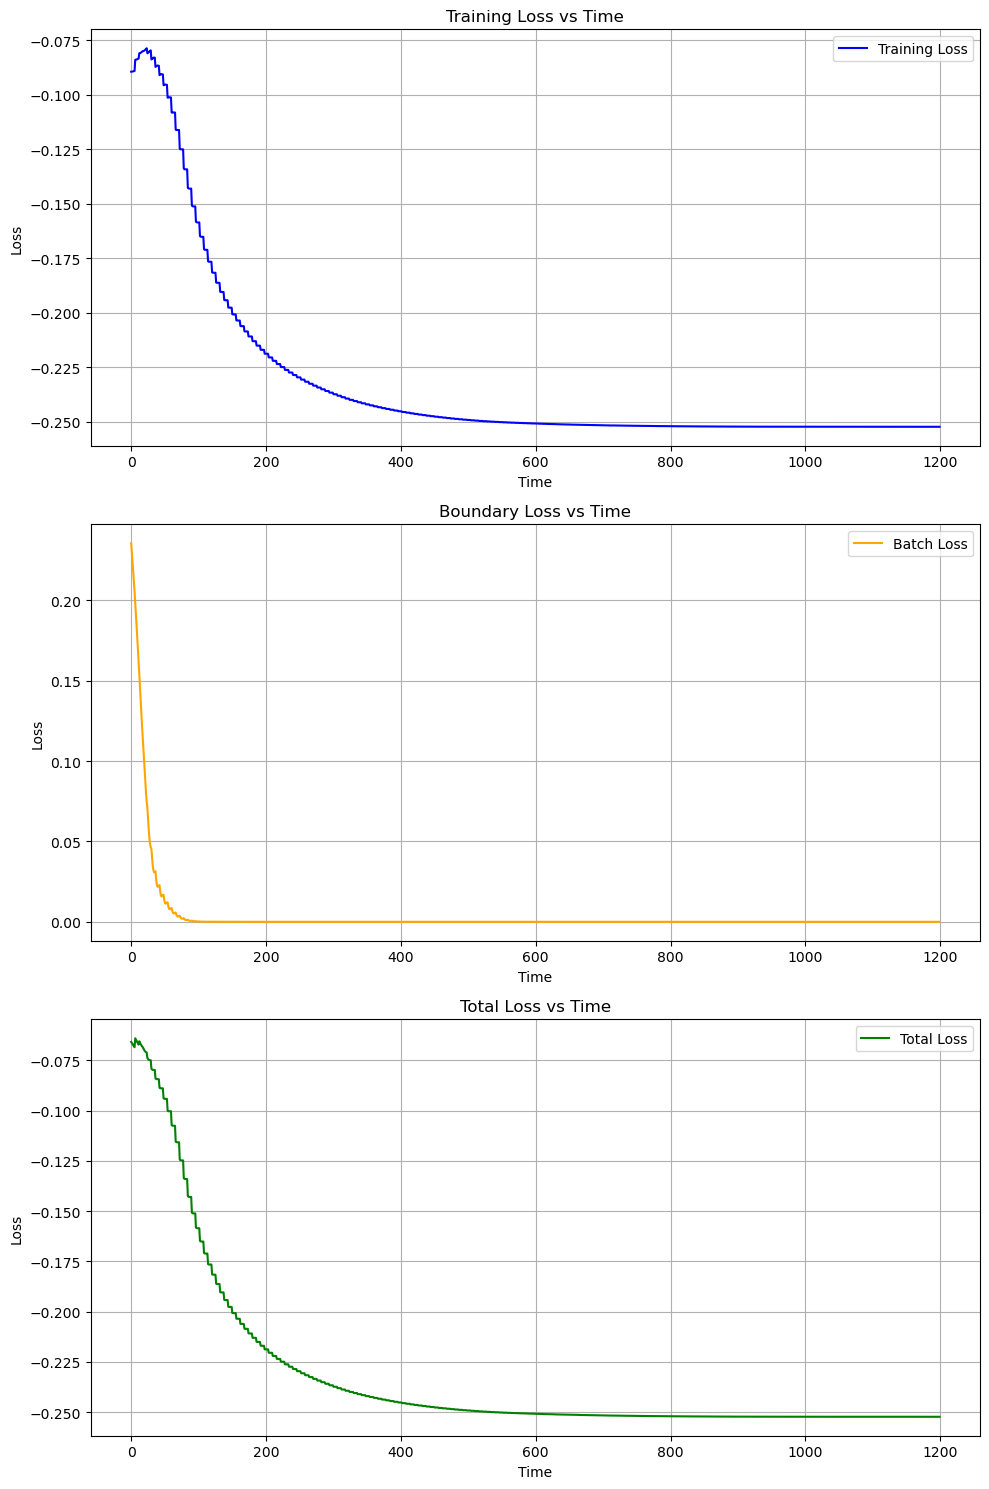

In [512]:
 # Length of the data  
t = np.arange(len(loss_list))  # Time values  


# Create a figure with 3 subplots  
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  

# Plot training loss  
axs[0].plot(t, loss_list, label='Training Loss', color='blue')  
axs[0].set_title('Training Loss vs Time')  
axs[0].set_xlabel('Time')  
axs[0].set_ylabel('Loss')  
axs[0].legend()  
axs[0].grid()  

# Plot batch loss  
axs[1].plot(t, b_loss_list, label='Batch Loss', color='orange')  
axs[1].set_title('Boundary Loss vs Time')  
axs[1].set_xlabel('Time')  
axs[1].set_ylabel('Loss')  
axs[1].legend()  
axs[1].grid()  

# Plot total loss  
axs[2].plot(t, tot_loss_list, label='Total Loss', color='green')  
axs[2].set_title('Total Loss vs Time')  
axs[2].set_xlabel('Time')  
axs[2].set_ylabel('Loss')  
axs[2].legend()  
axs[2].grid()  

# Adjust layout  
plt.tight_layout()  
plt.show()  

In [513]:
xmin, xmax = -1, 1
vmin, vmax = -3*np.sqrt(kbt), 3*np.sqrt(kbt)
dx = 0.001
dv = 0.01*np.sqrt(kbt)
Nx = int((xmax - xmin) / dx)
Nv = int((vmax - vmin) / dv)
#kbt = .1
#gamma = .1

Ncol = Nx - 1
Nrow = Nv + 1
x = np.linspace(xmin, xmax, Nx + 1)
v = np.linspace(vmin, vmax, Nv + 1)

if Ncol == Nx - 1:
    xcal = x[1:-1]
else:
    xcal = x

if Nrow == Nv - 1:
    vcal = v[1:-1]
else:
    vcal = v


X, V = np.meshgrid(xcal, vcal)
# print(X.shape, V)

points = np.array([X.reshape(-1), V.reshape(-1)]).T.astype(np.float32)
'''
c = np.arange(len(points))
plt.scatter(points[:, 0], points[:, 1], c=c)
plt.colorbar()
plt.show()
'''
N_matrix = Nrow * Ncol

ddd = torch.from_numpy(points).to(device)
qqq = q(ddd).squeeze().to('cpu').detach()





In [514]:
fd = np.loadtxt('./model/fd_g5_kbt.1.txt')
q0 = np.loadtxt('./model/fd_g.5_kbt.1_q0.txt')
q_simulation = np.loadtxt('./model/q_s_1d.txt')


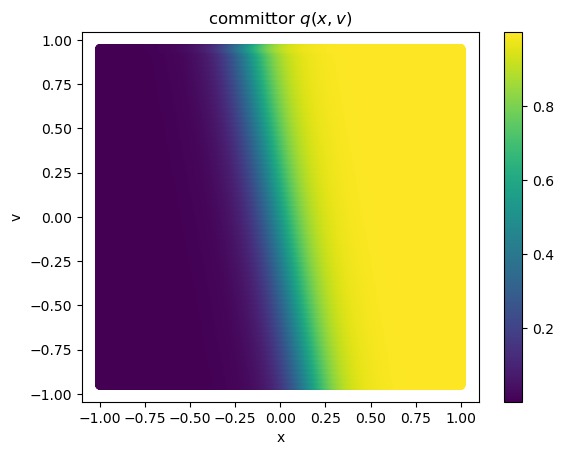

In [515]:
plt.scatter(points[:, 0], points[:, 1], c=qqq)
plt.title('committor $q(x,v)$')
plt.xlabel('x')
plt.ylabel('v')
plt.colorbar()
plt.show()

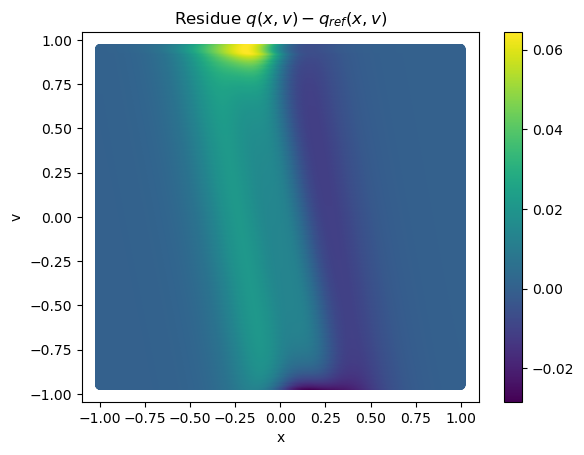

In [516]:
plt.scatter(points[:, 0], points[:, 1], c=qqq-fd[:,2])
plt.title('Residue $q(x,v)-q_{ref}(x,v)$')
plt.xlabel('x')
plt.ylabel('v')
plt.colorbar()
plt.show()

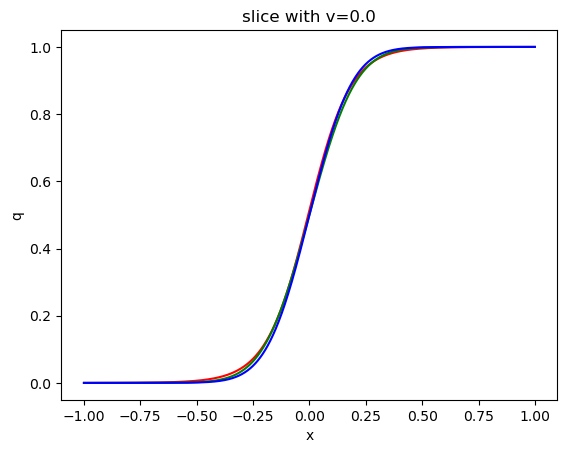

In [517]:
vslice = 0.0
Q = qqq.reshape(X.shape)
Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])
# plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r')
plt.plot(xcal[:], q0,'g')
plt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b')
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.title(f'slice with v={vslice}')
plt.show()

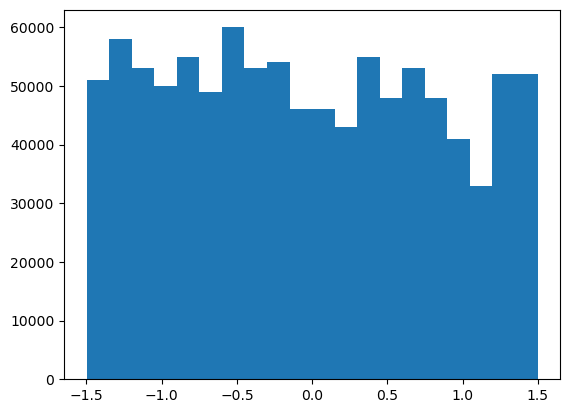

In [518]:
plt.hist(data.to('cpu').detach().numpy()[:,0],bins=20)
plt.show()

In [519]:
# model_file = f'./model/gamma{gamma}_kbt{kbt}_{lam}I.pth'
# config_file = f'./config/gamma{gamma}_kbt{kbt}_{lam}I.txt'
# save_model(q,model_file,config_file)

In [520]:
qmean = np.zeros_like(q0)

for i in range(qmean.shape[0]):
    
    v = torch.randn(size=(10000,1),dtype=torch.float32)*np.sqrt(kbt)
    xi = xcal[i]*torch.ones_like(v)
    ddd = torch.cat((xi,v),dim=1).to(device)
    qqq = q(ddd)
    qmean[i] = qqq.mean().item()

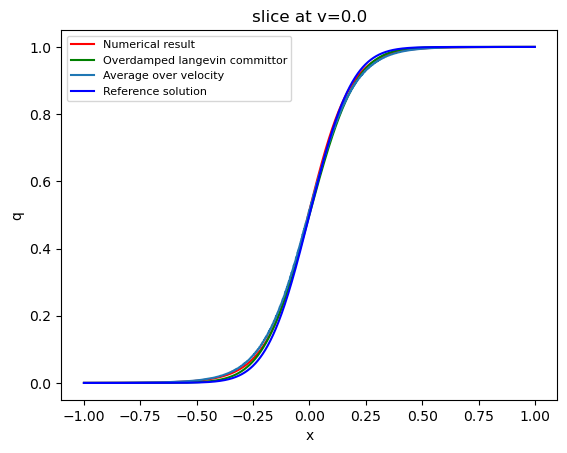

In [523]:
vslice = 0.0
#Q = qqq.reshape(X.shape)
Qfd = fd[:,2].reshape(X.shape)
#plt.plot(xcal[::10], Q[int((vslice-vmin)/dv), ::10]-Qfd[int((vslice-vmin)/dv), ::10])
#plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :]-Qfd[int((vslice-vmin)/dv), :])
plt.plot(xcal[:], Q[int((vslice-vmin)/dv), :],'r',label = 'Numerical result')
plt.plot(xcal[:], q0,'g',label = 'Overdamped langevin committor')
plt.plot(xcal[:], qmean,label = 'Average over velocity')
plt.plot(xcal[:],Qfd[int((vslice-vmin)/dv), :],'b',label='Reference solution')
#plt.plot(xcal, Q[int((vslice-vmin)/dv), :])
plt.xlabel('x')
plt.ylabel('q')
plt.legend(loc = 'upper left',fontsize=8)
plt.title(f'slice at v={vslice}')
plt.show()